Fetching data from: https://www.numbeo.com/cost-of-living/rankings.jsp?title=2025
  Cost of Living Index for Istanbul: 39.8
  Cost of Living Index for Ankara: 35.5
  Cost of Living Index for Antalya: 35.5
  Cost of Living Index for Izmir: 35.1
  Cost of Living Index for Bursa: 31.4

Gathered Cost of Living Data for Turkey: {'Istanbul': 39.8, 'Ankara': 35.5, 'Antalya': 35.5, 'Izmir': 35.1, 'Bursa': 31.4}


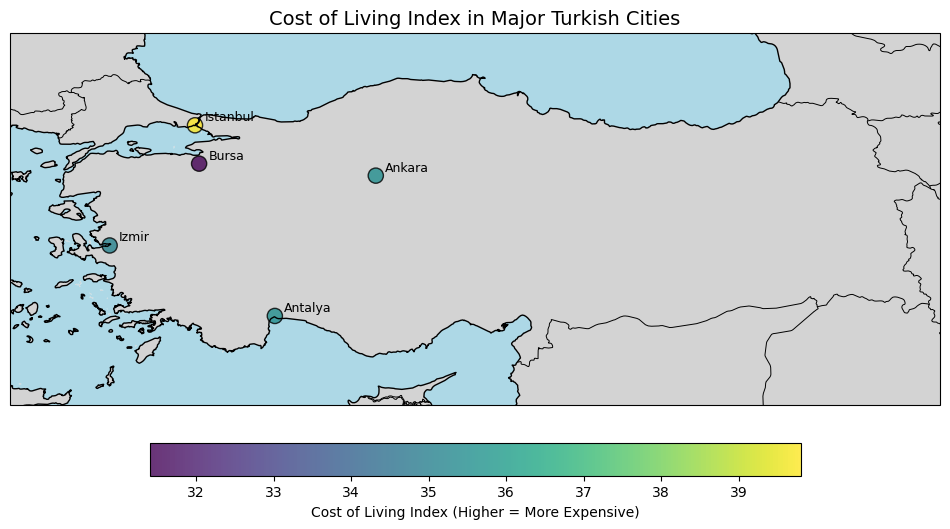

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime as dt

# Define year and URL
dt_year = dt.datetime.now()
current_year = dt_year.year
base_url = "https://www.numbeo.com/cost-of-living/rankings.jsp?title="
base_url_rankings = base_url + str(current_year)
print(f"Fetching data from: {base_url_rankings}")

#cities_turkey = ["Ankara", "Istanbul", "Izmir", "Bursa", "Antalya"]
cities_turkey = ["Ankara", "Istanbul", "Izmir", "Bursa", "Antalya", "Adana", "Gaziantep", "Konya", "Mersin", "Eskisehir", "Samsun", "Kocaeli"]
cost_of_living_data = {}

try:
    response = requests.get(base_url_rankings, timeout=10)
    response.raise_for_status()
    soup = BeautifulSoup(response.content, 'html.parser')
    rankings_table = soup.find('table', id='t2')

    if rankings_table:
        tbody = rankings_table.find('tbody')
        if tbody:
            rows = tbody.find_all('tr', style="width: 100%")
            for row in rows:
                columns = row.find_all('td')
                if len(columns) >= 3:
                    city_element = columns[1]
                    col_index_element = columns[2]
                    if city_element and col_index_element: #if both the city_element and the col_index_element columns exists, continue
                        # breaks here 
                        city = city_element.get_text(strip=True).split(',')[0].strip()
                        col_index_text = col_index_element.get_text(strip=True)
                        try:
                            cost_of_living_index = float(col_index_text)
                            if city in cities_turkey:
                                cost_of_living_data[city] = cost_of_living_index
                                print(f"  Cost of Living Index for {city}: {cost_of_living_index}")
                        except ValueError:
                            print(f"  Could not convert COL index for {city} to a number.")
                    else: 
                        print("if city_element and col_index_element dont doesn't exist??")

    time.sleep(1)
except requests.exceptions.RequestException as e:
    print(f"  Error fetching data from {base_url_rankings}: {e}")

print("\nGathered Cost of Living Data for Turkey:", cost_of_living_data)

# Coordinates for Turkish cities
city_coordinates = {
    "Istanbul": (41.0082, 28.9784),
    "Ankara": (39.9255, 32.8663),
    "Izmir": (38.4237, 27.1428),
    "Bursa": (40.1833, 29.0667),
    "Antalya": (36.9081, 30.6956),
    "Adana": (37.000000, 35.321335),
    "Gaziantep": (37.066666, 37.383331),
    "Konya": (37.9838, 32.7181),
    "Mersin": (36.8121, 34.6415),
    "Eskisehir": (39.7830, 30.5170),
    "Samsun": (41.2895, 36.3393),
    "Kocaeli": (40.8520, 29.8780),
}

# Build DataFrame
data = []
for city, cost in cost_of_living_data.items():
    if city in city_coordinates:
        lat, lon = city_coordinates[city]
        data.append({'city': city, 'latitude': lat, 'longitude': lon, 'cost_of_living': cost})
df = pd.DataFrame(data)

# Plot with Cartopy
if not df.empty:
    fig = plt.figure(figsize=(12, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set extent to Turkey roughly
    ax.set_extent([25, 45, 35, 43], crs=ccrs.PlateCarree())

    # Add features
    ax.add_feature(cfeature.BORDERS, linewidth=0.7)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.set_title('Cost of Living Index in Major Turkish Cities', fontsize=14)

    # Normalize color scale
    norm = plt.Normalize(vmin=df['cost_of_living'].min(), vmax=df['cost_of_living'].max())
    scatter = ax.scatter(df['longitude'], df['latitude'], c=df['cost_of_living'],
                         cmap='viridis', norm=norm, s=120, edgecolors='black', alpha=0.8)

    # Annotations
    for _, row in df.iterrows():
        ax.text(row['longitude'] + 0.2, row['latitude'] + 0.1, row['city'], fontsize=9)

    # Add colorbar
    cbar = plt.colorbar(scatter, orientation='horizontal', pad=0.05, shrink=0.7)
    cbar.set_label('Cost of Living Index (Higher = More Expensive)')
    plt.show()
else:
    print("No data to display on the map.")